# AutoMat

In [1]:
!pip install datasets piq matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 KB 7.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 KB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 66.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 KB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 11.0 MB/s eta 0:

## Dataset

In [2]:
from datasets import load_dataset

import gc
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from datasets import load_dataset
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [3]:
batch_size = 16
learning_rate = 1e-3
num_epochs = 50
latent_dim = 128

In [4]:
class TexturesDataset(Dataset):
    def __init__(self, split="train"):
        raw_dataset = load_dataset(
            "dream-textures/textures-color-normal-1k", split=split
        )
        self.valid_samples = []

        for i in range(len(raw_dataset)):
            if i == 465:
                continue

            sample = raw_dataset[i]

            color, normal = sample["color"], sample["normal"]
            if (
                isinstance(color, Image.Image)
                and color.mode == "RGB"
                and isinstance(normal, Image.Image)
                and normal.mode == "RGB"
            ):
                self.valid_samples.append(sample)
            else:
                print(
                    f"Skipping sample {i}: invalid mode. Color: {getattr(color, 'mode', None)}, Normal: {getattr(normal, 'mode', None)}"
                )

        print(
            f"Loaded {len(self.valid_samples)} valid RGB samples out of {len(raw_dataset)}."
        )

        self.transform = transforms.Compose(
            [transforms.Resize((512, 512)), transforms.ToTensor()]
        )

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        sample = self.valid_samples[idx]
        color = self.transform(sample["color"])
        normal = self.transform(sample["normal"])
        return torch.cat((color, normal), dim=0)

In [5]:
dataset = TexturesDataset()


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42)
)

README.md:   0%|          | 0.00/2.72k [00:00<?, ?B/s]

(…)-00000-of-00001-7d3033d434a1d73a.parquet:   0%|          | 0.00/111M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1426 [00:00<?, ? examples/s]

Skipping sample 35: invalid mode. Color: L, Normal: RGB
Skipping sample 155: invalid mode. Color: L, Normal: RGB
Skipping sample 300: invalid mode. Color: L, Normal: RGB
Skipping sample 366: invalid mode. Color: L, Normal: RGB
Skipping sample 495: invalid mode. Color: L, Normal: RGB
Skipping sample 713: invalid mode. Color: L, Normal: RGB
Skipping sample 728: invalid mode. Color: L, Normal: RGB
Skipping sample 734: invalid mode. Color: L, Normal: RGB
Skipping sample 791: invalid mode. Color: L, Normal: RGB
Skipping sample 805: invalid mode. Color: L, Normal: RGB
Skipping sample 847: invalid mode. Color: L, Normal: RGB
Skipping sample 863: invalid mode. Color: L, Normal: RGB
Skipping sample 879: invalid mode. Color: L, Normal: RGB
Skipping sample 1056: invalid mode. Color: L, Normal: RGB
Skipping sample 1090: invalid mode. Color: L, Normal: RGB
Skipping sample 1227: invalid mode. Color: L, Normal: RGB
Skipping sample 1262: invalid mode. Color: L, Normal: RGB
Skipping sample 1331: invali

In [6]:
train_dataset[0].shape

torch.Size([6, 512, 512])

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [8]:
class SkipConnectionAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(SkipConnectionAutoencoder, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(6, 64, 4, stride=2, padding=1), nn.ReLU()  # -> (64, 256, 256)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU()  # -> (128, 128, 128)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU()  # -> (256, 64, 64)
        )

        self.bottleneck_enc = nn.Sequential(
            nn.Flatten(), nn.Linear(256 * 64 * 64, latent_dim)
        )
        self.bottleneck_dec = nn.Sequential(
            nn.Linear(latent_dim, 256 * 64 * 64),
            nn.ReLU(),
            nn.Unflatten(1, (256, 64, 64)),
        )

        # Decoder layers
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(
                256 * 2, 128, 4, stride=2, padding=1
            ),  # Input channels doubled for skip connection
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(
                128 * 2, 64, 4, stride=2, padding=1
            ),  # Input channels doubled for skip connection
            nn.ReLU(),
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(
                64 * 2, 6, 4, stride=2, padding=1
            ),  # Input channels doubled for skip connection
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encoder path with saved feature maps
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)

        # Bottleneck
        z = self.bottleneck_enc(e3)
        d3 = self.bottleneck_dec(z)

        # Decoder path with skip connections
        # Concatenate decoder features with corresponding encoder features
        d3_skip = torch.cat([d3, e3], dim=1)  # Skip connection from encoder to decoder
        d2 = self.dec3(d3_skip)

        d2_skip = torch.cat([d2, e2], dim=1)  # Skip connection from encoder to decoder
        d1 = self.dec2(d2_skip)

        d1_skip = torch.cat([d1, e1], dim=1)  # Skip connection from encoder to decoder
        output = self.dec1(d1_skip)

        return output

## Training

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = SkipConnectionAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using device: cuda


In [18]:
loss_values = []

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)        
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    loss_values.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/50], Loss: 0.0148
Epoch [2/50], Loss: 0.0045
Epoch [3/50], Loss: 0.0035
Epoch [4/50], Loss: 0.0030
Epoch [5/50], Loss: 0.0026
Epoch [6/50], Loss: 0.0022
Epoch [7/50], Loss: 0.0020
Epoch [8/50], Loss: 0.0018
Epoch [9/50], Loss: 0.0016
Epoch [10/50], Loss: 0.0014
Epoch [11/50], Loss: 0.0014
Epoch [12/50], Loss: 0.0012
Epoch [13/50], Loss: 0.0011
Epoch [14/50], Loss: 0.0010
Epoch [15/50], Loss: 0.0010
Epoch [16/50], Loss: 0.0015
Epoch [17/50], Loss: 0.0011
Epoch [18/50], Loss: 0.0010
Epoch [19/50], Loss: 0.0010
Epoch [20/50], Loss: 0.0010
Epoch [21/50], Loss: 0.0009
Epoch [22/50], Loss: 0.0008
Epoch [23/50], Loss: 0.0008
Epoch [24/50], Loss: 0.0007
Epoch [25/50], Loss: 0.0008
Epoch [26/50], Loss: 0.0007
Epoch [27/50], Loss: 0.0006
Epoch [28/50], Loss: 0.0006
Epoch [29/50], Loss: 0.0006
Epoch [30/50], Loss: 0.0006
Epoch [31/50], Loss: 0.0006
Epoch [32/50], Loss: 0.0005
Epoch [33/50], Loss: 0.0005
Epoch [34/50], Loss: 0.0005
Epoch [35/50], Loss: 0.0005
Epoch [36/50], Loss: 0.0005
E

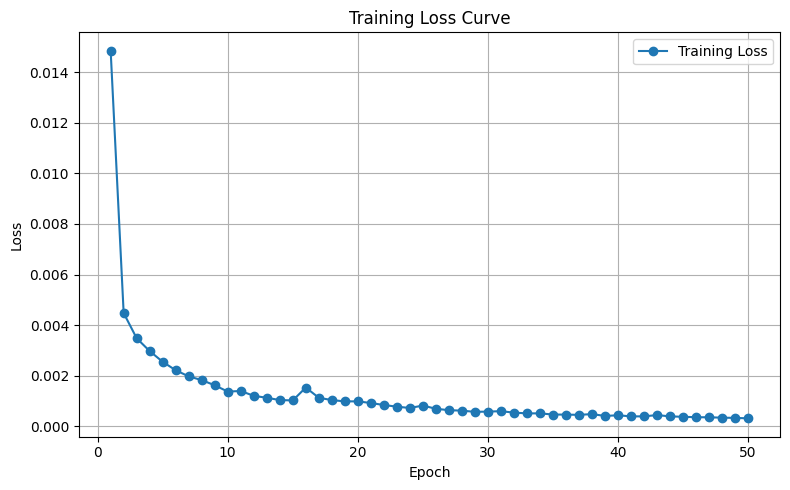

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Inference

In [11]:
from piq import psnr, ssim, multi_scale_ssim

In [12]:
def evaluate(model):
    model.eval()
    
    # Initialize metrics
    total_psnr = 0
    total_ssim = 0
    total_mse = 0
    total_ms_ssim = 0
    num_samples = 0
    
    # Turn off gradients during testing to save memory and computation
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
    
            # Calculate PSNR, SSIM, and MSE between input (data) and output (reconstructed)
            psnr_value = psnr(output, data)
            ssim_value = ssim(output, data, data_range=1.0)
            mse_value = nn.MSELoss()(output, data)
            ms_ssim_value = multi_scale_ssim(output, data, data_range=1.0)
    
            # Aggregate the metrics
            total_psnr += psnr_value.item()
            total_ssim += ssim_value.item()
            total_mse += mse_value.item()
            total_ms_ssim += ms_ssim_value.item()
            num_samples += 1
    
    # Calculate average metrics
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    avg_mse = total_mse / num_samples
    avg_ms_ssim = total_ms_ssim / num_samples
    
    # Print out the results
    print(f"Test Metrics:")
    print(f"Average PSNR: {avg_psnr:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MS-SSIM: {avg_ms_ssim:.4f}")

In [13]:
evaluate(model)

Test Metrics:
Average PSNR: 34.4221
Average SSIM: 0.9717
Average MSE: 0.0005
Average MS-SSIM: 0.9821


## Loss Functions

In [32]:
def get_loss_function(name="mse"):
    if name == "mse":
        return lambda x, y: nn.functional.mse_loss(x, y)
    elif name == "l1":
        return lambda x, y: nn.functional.l1_loss(x, y)
    elif name == "ssim":
        return lambda x, y: 1 - piq.ssim(x, y, data_range=1.0)
    elif name == "ms-ssim":
        return lambda x, y: 1 - piq.multi_scale_ssim(x, y, data_range=1.0)
    else:
        raise ValueError(f"Unknown loss function: {name}")


In [30]:
loss_functions = ["mse", "l1", "ssim", "ms-ssim"]

for loss_name in loss_functions:
    print(f"\nTraining with {loss_name.upper()} loss\n" + "-" * 40)

    model = SkipConnectionAutoencoder(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = get_loss_function(loss_name)

    for epoch in range(5):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/5], Loss: {total_loss / len(train_loader):.4f}")

    evaluate(model)
    
    del model, optimizer
    torch.cuda.empty_cache()
    gc.collect()


Training with MSE loss
----------------------------------------
Epoch [1/5], Loss: 0.0156
Epoch [2/5], Loss: 0.0050
Epoch [3/5], Loss: 0.0037
Epoch [4/5], Loss: 0.0032
Epoch [5/5], Loss: 0.0030
Test Metrics:
Average PSNR: 26.6345
Average SSIM: 0.8283
Average MSE: 0.0030
Average MS-SSIM: 0.8847

Training with L1 loss
----------------------------------------
Epoch [1/5], Loss: 0.0871
Epoch [2/5], Loss: 0.0478
Epoch [3/5], Loss: 0.0407
Epoch [4/5], Loss: 0.0387
Epoch [5/5], Loss: 0.0368
Test Metrics:
Average PSNR: 26.9646
Average SSIM: 0.7852
Average MSE: 0.0034
Average MS-SSIM: 0.8427

Training with SSIM loss
----------------------------------------
Epoch [1/5], Loss: 0.2942
Epoch [2/5], Loss: 0.0798
Epoch [3/5], Loss: 0.0433
Epoch [4/5], Loss: 0.0313
Epoch [5/5], Loss: 0.0271
Test Metrics:
Average PSNR: 20.3198
Average SSIM: 0.9796
Average MSE: 0.0095
Average MS-SSIM: 0.9464

Training with MS-SSIM loss
----------------------------------------
Epoch [1/5], Loss: 0.2179
Epoch [2/5], Loss

# Hybrid Loss Function


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = SkipConnectionAutoencoder().to(device)
mse_loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
alpha = 0.2

Using device: cuda


In [14]:
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        mse = mse_loss(output, data)
        ms_ssim_loss = 1 - multi_scale_ssim(output, data, data_range=1.0, reduction="mean")
        loss = alpha * mse + (1 - alpha) * ms_ssim_loss
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/50], Loss: 0.1751
Epoch [2/50], Loss: 0.0610
Epoch [3/50], Loss: 0.0486
Epoch [4/50], Loss: 0.0318
Epoch [5/50], Loss: 0.0252
Epoch [6/50], Loss: 0.0203
Epoch [7/50], Loss: 0.0165
Epoch [8/50], Loss: 0.0142
Epoch [9/50], Loss: 0.0131
Epoch [10/50], Loss: 0.0126
Epoch [11/50], Loss: 0.0119
Epoch [12/50], Loss: 0.0111
Epoch [13/50], Loss: 0.0107
Epoch [14/50], Loss: 0.0106
Epoch [15/50], Loss: 0.0102
Epoch [16/50], Loss: 0.0099
Epoch [17/50], Loss: 0.0101
Epoch [18/50], Loss: 0.0092
Epoch [19/50], Loss: 0.0091
Epoch [20/50], Loss: 0.0088
Epoch [21/50], Loss: 0.0086
Epoch [22/50], Loss: 0.0083
Epoch [23/50], Loss: 0.0083
Epoch [24/50], Loss: 0.0081
Epoch [25/50], Loss: 0.0078
Epoch [26/50], Loss: 0.0080
Epoch [27/50], Loss: 0.0073
Epoch [28/50], Loss: 0.0075
Epoch [29/50], Loss: 0.0071
Epoch [30/50], Loss: 0.0070
Epoch [31/50], Loss: 0.0069
Epoch [32/50], Loss: 0.0071
Epoch [33/50], Loss: 0.0066
Epoch [34/50], Loss: 0.0068
Epoch [35/50], Loss: 0.0065
Epoch [36/50], Loss: 0.0065
E

In [15]:
evaluate(model)

Test Metrics:
Average PSNR: 26.7770
Average SSIM: 0.9875
Average MSE: 0.0022
Average MS-SSIM: 0.9938


In [20]:
import gc

# del x, optimizer
torch.cuda.empty_cache()
gc.collect()

2812